In [14]:
# imports
import pandas as p
import numpy as np
from sklearn.cluster import DBSCAN
import hdbscan as hdbs                       # https://github.com/scikit-learn-contrib/hdbscan, https://joss.theoj.org/papers/10.21105/joss.00205
import matplotlib.pyplot as plt
import gc                               # garbage collector
import shapely as shpl
import datetime as dt

# constants
FOLDER_PATH = "../dataset/2019/"
FILE_NAME = 'cleaned_2019_01-03.csv'
SPEED_THRESHOLD = 0.25 # nautical knots
POINTS_THRESHOLD = 50
KNOTS_CONST = 1.943845249221964 # constant used to convert from m/s to nautical knots
EARTH_RADIUS_KM = 6378.137 # average value, used by geopy https://github.com/geopy/geopy/blob/master/geopy/distance.py
EARTH_RADIUS_M = 6378137
LAT_MIN = 18.76651
LAT_MAX = 22.63089
LON_MIN = -160.11085
LON_MAX = -154.38957
LOST_TIME_THRESHOLD_SECONDS = dt.timedelta(seconds=600) # 10 minutes

Import source csv into a dataframe

In [2]:
clean_df = p.read_csv(FOLDER_PATH + FILE_NAME)
print(f'Dataframe shape: {clean_df.shape}')
print(clean_df.columns)
print(clean_df.shape)

/tmp/ipykernel_7512/4039637272.py:1: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_df = p.read_csv(FOLDER_PATH + FILE_NAME)


Dataframe shape: (5415168, 17)
Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'TransceiverClass'],
      dtype='object')
(5415168, 17)


Columns dtypes optimization in order to reduce RAM usage <br>
(=casting to smaller dtypes)

In [3]:
optimized_df = p.DataFrame()

# MMSI - 9 digits number, converted from int64 to int32
optimized_df['MMSI'] = clean_df['MMSI'].astype('int32')

# BaseDateTime - from str to numpy.datetime64 (68 bytes -> 40 Bytes)
optimized_df['BaseDateTime'] = clean_df['BaseDateTime'].astype('datetime64[s]')

# LAT - No action. Just want to make sure to not loose precision 
optimized_df['LAT'] = clean_df['LAT']

# LON - No action. Just want to make sure to not loose precision 
optimized_df['LON'] = clean_df['LON']

# SOG - No action
optimized_df['SOG'] = clean_df['SOG']

# COG - from float64 to float32. The loss of precision is negligible, as per AIS specs
# the maximum allowed value is 360 degrees, relative to true north
optimized_df['COG'] = clean_df['COG'].astype('float32')

# Heading - from float64 to float32. The loss of precision is negligible, as per AIS specs
# the maximum allowed value is 511, meaning 'no data'.
optimized_df['Heading'] = clean_df['Heading'].astype('float32')

# VesselName - specify string dtype
optimized_df['VesselName'] = clean_df['VesselName'].astype(p.StringDtype())

# IMO - specify string dtype
optimized_df['IMO'] = clean_df['IMO'].astype(p.StringDtype())

# CallSign - specify string dtype
optimized_df['CallSign'] = clean_df['CallSign'].astype(p.StringDtype())

# VesselType - from float64 to int16. Following AIS specification, VesselType maximum value is around 1000
clean_df['VesselType'] = clean_df['VesselType'].fillna(value=0) # replaces all None values with zero.
optimized_df['VesselType'] = clean_df['VesselType'].astype('int16')

# Status - from float64 to int8. Following AIS specification, there are 16 (0-15) status codes
clean_df['Status'] = clean_df['Status'].fillna(value=99) # since 0 is a valid status code, 99 is used as a placeholder for None values
optimized_df['Status'] = clean_df['Status'].astype('int8')

# Length - from float64 to int16. Any floating point value is truncated to the closest integer.
# This is done on purpouse as an error of fractions of a meter is bearable.
clean_df['Length'] = clean_df['Length'].fillna(value=0)
optimized_df['Length'] = clean_df['Length'].astype('int16')

# Width - from float64 to int16. Any floating point value is truncated to the closest integer.
# This is done on purpouse as an error of fractions of a meter is bearable.
clean_df['Width'] = clean_df['Width'].fillna(value=0)
optimized_df['Width'] = clean_df['Width'].astype('int16')

# Draft - from float64 to float32
optimized_df['Draft'] = clean_df['Draft'].astype('float32')

# Cargo - from float64 to int16. Similar to VesselType
clean_df['Cargo'] = clean_df['Cargo'].fillna(value=0)
optimized_df['Cargo'] = clean_df['Cargo'].astype('int16')

# TransceiverClass - from string object to boolean. The new column ('IsClassA') holds True if the transceiver 
# is of type 'class A', false if it is of type 'class B'
optimized_df['IsClassA'] = clean_df['TransceiverClass'].map({'A':True, 'B':False})

# Round lat and lon values to 4 decimal digits (instead of 5)
optimized_df[['LAT','LON']] = optimized_df[['LAT','LON']].round(4)

print(clean_df.info())

print(optimized_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415168 entries, 0 to 5415167
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   MMSI              int64  
 1   BaseDateTime      object 
 2   LAT               float64
 3   LON               float64
 4   SOG               float64
 5   COG               float64
 6   Heading           float64
 7   VesselName        object 
 8   IMO               object 
 9   CallSign          object 
 10  VesselType        float64
 11  Status            float64
 12  Length            float64
 13  Width             float64
 14  Draft             float64
 15  Cargo             float64
 16  TransceiverClass  object 
dtypes: float64(11), int64(1), object(5)
memory usage: 702.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415168 entries, 0 to 5415167
Data columns (total 17 columns):
 #   Column        Dtype        
---  ------        -----        
 0   MMSI          int32        
 1   BaseDateTim

Source: Pallotta, G., Vespe, M., & Bryan, K. (2013). Vessel Pattern Knowledge Discovery from AIS Data: A Framework for Anomaly Detection and Route Prediction. Entropy, 15(12), 2218–2245. https://doi.org/10.3390/e15062218

‌TREAD algorithm (pages 2223-2231)

In [4]:
def great_circle_distance_vectorized(lat_left, lon_left, lat_right, lon_right):
    '''Function used to calculate the Great-Circle distance between two GPS coordinates'''    
    lon_left, lat_left, lon_right, lat_right = map(np.radians, [lon_left, lat_left, lon_right, lat_right])
    deg_lon = lon_right - lon_left
    deg_lat = lat_right - lat_left
    a = np.sin(deg_lat/2.0)**2 + np.cos(lat_left) * np.cos(lat_right) * np.sin(deg_lon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    meters = EARTH_RADIUS_M * c
    return meters

V_s = [] # List of dataframes. Each dataframe represents a Vessel (and its journey)

# From the complete db, select only the necessary columns
optimized_df = optimized_df[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
                            'VesselName', 'VesselType', 'Status', 'Length',
                            'Width', 'Draft', 'IsClassA']].copy()
# Drop duplicates, just in case
optimized_df.drop_duplicates(subset=['MMSI', 'BaseDateTime'], keep='first', inplace=True, ignore_index=True)
optimized_df = optimized_df.sort_values(by='BaseDateTime')

reference_list_of_mmsi = p.unique(optimized_df['MMSI'])

# for each ship
for mmsi in reference_list_of_mmsi:
    # Extract all points generated by the ship
    appendDF = p.DataFrame(optimized_df[optimized_df['MMSI'] == mmsi])
    # Add a new column for storing the average speed between the current point and the previous
    appendDF['Avg_Speed'] = p.Series(dtype=p.Float64Dtype())
    # Add a new column for storing the status of the ship (according to TREAD algorithm, see above)
    appendDF['EstimatedStatus'] = np.nan
    # Rename the dataframe to the corresponding ship MMSI
    appendDF.Name = mmsi
    # reset the index of the dataframe
    appendDF.reset_index(inplace=True)

    # next step: calculate the avg_speed (distance/time) in order to find stationary points. (SOG is not always reliable)
    # for the distance, the great-circle distance is used in order to account for earth curvature
    
    # save a shifted-by-one-row version of the db, so that "previous" points can be joined with "current" points
    shiftedDF = appendDF[['BaseDateTime','LAT', 'LON']].shift(1).copy()
    # the resulting df has (for each row) a pair of points. The left one is antecedent to the right one
    pairsOfPointsDF = shiftedDF.iloc[1:].join(appendDF[['BaseDateTime', 'LAT', 'LON', 'SOG']].iloc[1:], lsuffix='_left', rsuffix='_right')
    # calculate average speed for each row of the 'pairsOfPointsDF' df (each row represents a pair of points)
    # add a new column that holds the time difference between the two points of the row
    pairsOfPointsDF['DeltaTime'] = p.to_datetime(pairsOfPointsDF['BaseDateTime_right']) - p.to_datetime(pairsOfPointsDF['BaseDateTime_left'])
    # add a new column that holds the distance (in meters) between the two points of the same row
    pairsOfPointsDF['Distance'] = great_circle_distance_vectorized( pairsOfPointsDF['LAT_left'],
                                                                    pairsOfPointsDF['LON_left'],
                                                                    pairsOfPointsDF['LAT_right'],
                                                                    pairsOfPointsDF['LON_right']
                                                                    )
    # calculate average speed (in m/s)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Distance'] / pairsOfPointsDF['DeltaTime'].dt.total_seconds()

    # sometimes a vessel can stop reporting its position and re-appear too far away from its last known location.
    # In this case it makes little sense to calculate the avg_speed. (np.nan multiplied by any number returns np.nan)
    
    # condition used to determine if the ship is "lost"
    lost_condition = (pairsOfPointsDF['DeltaTime'] > LOST_TIME_THRESHOLD_SECONDS)
    # the avg_speed of the points following the ones considered "lost" is set to nan
    pairsOfPointsDF.loc[lost_condition, 'Speed'] = np.nan
    # any nan point of the 'Speed' column is set to the corresponging 'SOG' value (if available)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].fillna(pairsOfPointsDF['SOG']/KNOTS_CONST)
    # new empty status column
    pairsOfPointsDF['EstimatedStatus'] = p.Series(dtype=p.StringDtype())
    # the status of the first point after the ship reappears is set to 'return'
    pairsOfPointsDF.loc[lost_condition, 'EstimatedStatus'] = 'return'
    # the status of last point before the ship disappears is set to 'lost'
    pairsOfPointsDF.loc[lost_condition.shift(-1, fill_value=False), 'EstimatedStatus'] = 'lost'
    
    # convert the speed from meters to nautical knots
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'] * KNOTS_CONST
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].round(decimals=2)
    
    # save the speed values to the ship df
    appendDF['Avg_Speed'] = pairsOfPointsDF['Speed'].copy()
    # round the final value to 2 decimal digits
    # The first row of each ship has its "Avg_Speed" field set equal to the SOG
    appendDF.at[appendDF.index[0], 'Avg_Speed'] = appendDF.at[appendDF.index[0], 'SOG']
    # Any row where avg_speed is set to np.nan is replaced with the SOG value
    appendDF.fillna({'Avg_Speed' : appendDF['SOG']}, inplace=True)
    # Copy the estimated status column in the final ship df
    appendDF['EstimatedStatus'] = pairsOfPointsDF['EstimatedStatus'].copy()
    # drop the first column (generated during all the processing above)
    appendDF.drop('index', axis=1, inplace=True)
    # save the dataframe to the vessels list
    V_s.append(appendDF)

print(V_s[-1])

           MMSI        BaseDateTime      LAT       LON   SOG         COG  \
0     248531000 2019-03-29 17:09:21  21.2406 -159.9439  11.7   89.099998   
1     248531000 2019-03-29 17:45:42  21.2409 -159.8170  11.9   89.300003   
2     248531000 2019-03-29 17:46:52  21.2409 -159.8130  11.8   90.199997   
3     248531000 2019-03-29 17:56:41  21.2409 -159.7782  11.9   91.199997   
4     248531000 2019-03-29 17:57:52  21.2409 -159.7740  12.0   90.800003   
...         ...                 ...      ...       ...   ...         ...   
1171  248531000 2019-03-31 23:43:55  21.2779 -158.0725   0.2    3.500000   
1172  248531000 2019-03-31 23:46:55  21.2779 -158.0725   0.2  174.600006   
1173  248531000 2019-03-31 23:52:55  21.2779 -158.0725   0.2  198.000000   
1174  248531000 2019-03-31 23:55:55  21.2779 -158.0725   0.1  182.100006   
1175  248531000 2019-03-31 23:58:55  21.2779 -158.0725   0.1  181.100006   

      Heading VesselName  VesselType  Status  Length  Width  Draft  IsClassA  \
0      

In [5]:
# delete unused dataframe from RAM in order to save memory
# according to StackOverflow, this is the best way: 
# https://stackoverflow.com/questions/64368565/delete-and-release-memory-of-a-single-pandas-dataframe

del pairsOfPointsDF
del appendDF
del shiftedDF
del clean_df
gc.collect()

25

Next part of the TREAD algorithm</br>

Consider as stationary all points where the estimated average speed is lower then a set threshold</br>
Consider the first (entry) and last (exit) recorded points of each ship as 'stationary', regardless of the estimated speed.</br>
Set all remaing points as 'sailing'</br>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40086 entries, 0 to 40085
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype        
---  ------           --------------  -----        
 0   MMSI             40086 non-null  int32        
 1   BaseDateTime     40086 non-null  datetime64[s]
 2   LAT              40086 non-null  float64      
 3   LON              40086 non-null  float64      
 4   SOG              40086 non-null  float64      
 5   COG              40086 non-null  float32      
 6   Heading          40086 non-null  float32      
 7   VesselName       40086 non-null  string       
 8   VesselType       40086 non-null  int16        
 9   Status           40086 non-null  int8         
 10  Length           40086 non-null  int16        
 11  Width            40086 non-null  int16        
 12  Draft            0 non-null      float32      
 13  IsClassA         40086 non-null  bool         
 14  Avg_Speed        40086 non-null  float64      
 15  Es

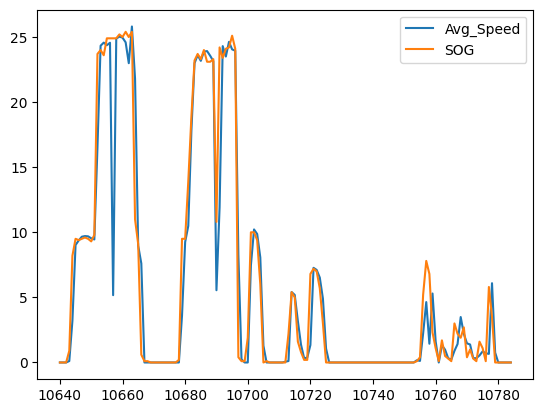

In [6]:
# for each vessel (dataframe) in the V_s list,
for shipDF in V_s:
    # set the status of each point where the avg_speed is lower than the given threshold, to 'stationary'
    shipDF['EstimatedStatus'] = np.where(((shipDF["Avg_Speed"] <= SPEED_THRESHOLD) &
                                         (shipDF['EstimatedStatus'].isnull())),
                                         'stationary', shipDF['EstimatedStatus'])
    # set all remaining points as "sailing"
    shipDF['EstimatedStatus'] = np.where(((shipDF["Avg_Speed"] > SPEED_THRESHOLD) & 
                                         (shipDF['EstimatedStatus'].isnull())),
                                          'sailing', shipDF['EstimatedStatus'])
    # set the first and last points of each ship as "entry" and "exit" points respectively
    shipDF.loc[shipDF.index[0:1], 'EstimatedStatus'] = 'entry'
    shipDF.loc[shipDF.index[-1:], 'EstimatedStatus'] = 'exit'
    
print(V_s[3].info())

del shipDF
gc.collect()

# print a dataframe and some points just to check
interval = range(10640,10785)
print(V_s[3].iloc[interval])
plt.plot(V_s[3]['Avg_Speed'].iloc[interval])
plt.plot(V_s[3]['SOG'].iloc[interval])
plt.legend(['Avg_Speed', 'SOG'])


In [7]:
# Extract all the stationary points in a single dataframe

stationaryDF = p.DataFrame(columns=V_s[0].columns) # new empty df

concatDF = p.concat(V_s, ignore_index=True).copy()

stationaryDF = concatDF[(concatDF['EstimatedStatus'] == 'stationary') |
                        (concatDF['EstimatedStatus'] == 'entry') |
                        (concatDF['EstimatedStatus'] == 'exit')
                        ].copy()

stationaryDF.reset_index(inplace=True)

print(stationaryDF.info())

print(f'{(stationaryDF.shape[0]/optimized_df.shape[0]) * 100: .2f}% of points are stationary!')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3533750 entries, 0 to 3533749
Data columns (total 17 columns):
 #   Column           Dtype        
---  ------           -----        
 0   index            int64        
 1   MMSI             int32        
 2   BaseDateTime     datetime64[s]
 3   LAT              float64      
 4   LON              float64      
 5   SOG              float64      
 6   COG              float32      
 7   Heading          float32      
 8   VesselName       string       
 9   VesselType       int16        
 10  Status           int8         
 11  Length           int16        
 12  Width            int16        
 13  Draft            float32      
 14  IsClassA         bool         
 15  Avg_Speed        float64      
 16  EstimatedStatus  object       
dtypes: bool(1), datetime64[s](1), float32(3), float64(4), int16(3), int32(1), int64(1), int8(1), object(1), string(1)
memory usage: 296.6+ MB
None
 65.26% of points are stationary!


In [8]:
# Some computationl tricks in order to save some time

# Group-by same (lat,lon) pairs and count occurrencies
groupedDF = stationaryDF.groupby(['LAT', 'LON']).size().reset_index(name='Weight')

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
groupedDF['Weight'] = np.round(
                                np.log2(groupedDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is replaced
groupedDF['Weight'] = groupedDF['Weight'].replace(0,1)

print(groupedDF)

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

Pair with most occurrencies: 
LAT          21.2970
LON        -158.1065
Weight    59924.0000
Name: 20908, dtype: float64

           LAT       LON  Weight
0      18.7669 -156.6011     1.0
1      18.7671 -159.1110     1.0
2      18.7677 -155.7892     1.0
3      18.7680 -158.2825     1.0
4      18.7682 -156.6366     1.0
...        ...       ...     ...
29786  22.6306 -156.1920     1.0
29787  22.6306 -156.1771     1.0
29788  22.6307 -156.9234     1.0
29789  22.6308 -158.4875     1.0
29790  22.6308 -156.8662     1.0

[29791 rows x 3 columns]
Pair with most occurrencies: 
LAT        21.2970
LON      -158.1065
Weight     16.0000
Name: 20908, dtype: float64



DBSCAN(eps=0.05) len: 29791, num of clusters: 62
           LAT       LON  Weight  Label
0      18.7669 -156.6011     1.0     -1
1      18.7671 -159.1110     1.0     -1
2      18.7677 -155.7892     1.0     -1
3      18.7680 -158.2825     1.0      0
4      18.7682 -156.6366     1.0     -1
...        ...       ...     ...    ...
29786  22.6306 -156.1920     1.0     -1
29787  22.6306 -156.1771     1.0     -1
29788  22.6307 -156.9234     1.0     -1
29789  22.6308 -158.4875     1.0     -1
29790  22.6308 -156.8662     1.0     -1

[29791 rows x 4 columns]


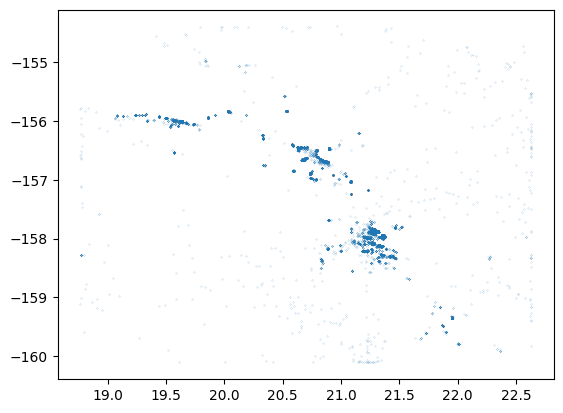

In [9]:
# Run DBSCAN algorithm on the stationary points

# this scatter plot gives a rough idea of how the point should look like plotted on a map
plt.scatter(groupedDF.iloc[:,0], groupedDF.iloc[:,1], s=0.01)

# inizitalize dbscan object with parameters. TODO: test multiple parameters combinations
dbscan = DBSCAN(eps=0.05, min_samples=5)

estimator = dbscan.fit(
                    X=groupedDF.iloc[:, 0:2], 
                    sample_weight=groupedDF['Weight']
                    )

print(str(estimator) + " len: " + str(len(estimator.labels_)) + ", num of clusters: " + str(max(estimator.labels_)))

# Add labels to the dataframe
groupedDF['Label'] = estimator.labels_

print(groupedDF)

In [10]:
# plot the result of the DBSCAN clustering on a map (to have a look at the effects of the parameters)
import plotly.express as px
import plotly.offline as po
import plotly.graph_objects as go
from scipy.spatial import ConvexHull


def points_plotter(clustered : p.DataFrame, not_clustered : p.DataFrame, model, dbscanFlag : bool):
    '''Function used to plot the results of dbscan and hdbscan\n
    Takes as input two dataframes: clusterd and not_clustered, both containing
    points that were successfully labelled or not, respectively'''
    if dbscanFlag:
        my_title = 'DBSCAN. Eps: ' + str(model.get_params()['eps']) + ', min_size: ' + str(model.get_params()['min_samples'])
    else:
        my_title = 'H-DBSCAN. Min Eps: ' + str(model.get_params()['cluster_selection_epsilon']) + \
            ', min_size: ' + str(model.get_params()['min_cluster_size']) + \
            ', max_size: ' + str(model.get_params()['max_cluster_size'])
    
    # plot clustered points on a map
    fig = px.scatter_mapbox(data_frame = clustered,
                            lon = clustered['LON'],
                            lat= clustered['LAT'],
                            zoom = 7,
                            color = clustered['Label'],
                            title = my_title,
                            color_continuous_scale='portland'  #portland
                            )

    # add unclustered points
    fig.add_scattermapbox(
                          lat= not_clustered['LAT'],
                          lon= not_clustered['LON'],
                          marker={'color':'white'},
                          uid=1
                          )

    # add domain border
    fig.add_trace(go.Scattermapbox(
                                    mode = 'lines',
                                    lon = [LON_MIN, LON_MIN, LON_MAX, LON_MAX, LON_MIN],
                                    lat = [LAT_MIN, LAT_MAX, LAT_MAX, LAT_MIN, LAT_MIN],
                                    marker = {'size':10,
                                              'color': 'red'},
                                    uid=2,
                                    below=0
                                    ))
    
    # Add polygons on map
    for label in clustered['Label'].unique():
        groupLATLONDF = clustered[clustered['Label']==label][['LAT', 'LON']]
        hull = ConvexHull(groupLATLONDF)
        hull_lon = [groupLATLONDF['LON'].reset_index().iloc[vertex] for vertex in hull.vertices]
        hull_lat = [groupLATLONDF['LAT'].reset_index().iloc[vertex] for vertex in hull.vertices]
    
        hull_lon = [serie.tolist()[1] for serie in hull_lon]
        hull_lat = [serie.tolist()[1] for serie in hull_lat]
    
        fig.add_trace(go.Scattermapbox(
            lat=hull_lat + [hull_lat[0]],
            lon=hull_lon + [hull_lon[0]],
            mode='lines',
            line=dict(color='black', width=2),
            below=0,
            showlegend=False,
            name='WP_' + str(label)
            #fill='toself',
            #fillcolor='rgba(255,0,0,0.2)'
        ))

    fig.update_layout(mapbox_style = 'open-street-map',
                      margin={'r':0, 't':40, 'l':0, 'b':0},
                      )
    po.plot(fig)

    

clusteredPointsDF = groupedDF[groupedDF['Label'] != -1].copy()
outliersDF = groupedDF[groupedDF['Label'] == -1].copy()
clusteredPointsDF.reset_index(inplace=True)
outliersDF.reset_index(inplace=True)

print(clusteredPointsDF)

points_plotter(clustered=clusteredPointsDF,
               not_clustered=outliersDF,
               model=estimator,
               dbscanFlag=True)



       index      LAT       LON  Weight  Label
0          3  18.7680 -158.2825     1.0      0
1          8  18.7689 -158.2837     1.0      0
2          9  18.7689 -158.2824     1.0      0
3         10  18.7689 -158.2820     1.0      0
4         11  18.7690 -158.2836     1.0      0
...      ...      ...       ...     ...    ...
29333  29765  22.6292 -158.2819     1.0     60
29334  29766  22.6292 -155.5306     1.0     61
29335  29770  22.6297 -156.4579     1.0     62
29336  29774  22.6298 -155.5223     1.0     61
29337  29776  22.6300 -155.5959     1.0     61

[29338 rows x 5 columns]


Hierarchical DBSCAN

In [11]:
# Since the current sklearn hdbscan implementation does not allow to pass the weights of points as input,
# the DataFrame that stores stationary points needs a little change: instead of passing the weights for each
# coordinate, each line representing a coordinate is going to be duplicated for the same amount specified by its own weight

print(f'The new DF should have about {groupedDF.shape[0]} * {groupedDF["Weight"].mean(), 3} = {groupedDF.shape[0] * groupedDF["Weight"].mean()} rows.')

repeated_indices = np.repeat(groupedDF.index, groupedDF['Weight'])

h_groupedDF = groupedDF.loc[repeated_indices, ['LAT', 'LON']].reset_index(drop=True)

print('Rows of the new DF: {}'.format(h_groupedDF.shape[0]))

print(f'The new DF, if a "groupby" is applied again, should have the same number of rows of the original: {h_groupedDF.value_counts().shape}')


The new DF should have about 29791 * (2.2830720687455943, 3) = 68015.0 rows.
Rows of the new DF: 68015
The new DF, if a "groupby" is applied again, should have the same number of rows of the original: (29791,)


In [27]:
# Run H-DBSCAN algorithm on the stationary points

# inizitalize dbscan object with parameters. TODO: test multiple parameters combinations
h_dbscan = hdbs.HDBSCAN(min_cluster_size=10,
                        cluster_selection_epsilon=0.06,
                        max_cluster_size=10_000)
'''
h_dbscan = hdbs.hdbscan(min_cluster_size=10,
                  cluster_selection_epsilon=0.06,
                  max_cluster_size=10_000
                  )
'''
h_labels = h_dbscan.fit_predict(
                    X=h_groupedDF.loc[:, ['LAT','LON']]
                    )

display(h_labels.shape)

print(str(h_dbscan) + " len: " + str(len(h_labels)) + ", num of clusters: " + str(max(h_labels)))

# Add labels to the dataframe
h_groupedDF['Label'] = h_labels


display(h_groupedDF)
#print(groupedDF['Label'].max())

(68015,)

HDBSCAN(cluster_selection_epsilon=0.06, max_cluster_size=10000,
        min_cluster_size=10) len: 68015, num of clusters: 56


,LAT,LON,Label
0,18.7669,-156.6011,-1
1,18.7671,-159.1110,1
2,18.7677,-155.7892,-1
3,18.7680,-158.2825,1
4,18.7682,-156.6366,-1
...,...,...,...
68010,22.6306,-156.1920,31
68011,22.6306,-156.1771,31
68012,22.6307,-156.9234,-1
68013,22.6308,-158.4875,-1


In [ ]:
# Show the result of h-dbscan on a map

clusteredPointsDF = h_groupedDF[h_groupedDF['Label'] != -1].copy()
outliersDF = h_groupedDF[h_groupedDF['Label'] == -1].copy()

points_plotter(clustered=clusteredPointsDF,
               not_clustered=outliersDF,
               model=h_labels,
               dbscanFlag=False)

Plot a heatmap using all the points, even the non-stationary ones

In [ ]:
%%script false --no-raise-error
# the code above is used to prevent the Python kernel from running this cell (https://stackoverflow.com/a/56247673/24805169)


concatDF[['LAT','LON']] = concatDF[['LAT','LON']].round(3)

heatmapDF = concatDF.groupby(['LAT','LON']).size().reset_index(name='Weight')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
heatmapDF['Weight'] = np.round(
                                np.log2(heatmapDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is replaced
#heatmapDF['Weight'].replace(0,1,inplace=True)


print("Pair with most occurrencies: \n" + str(heatmapDF.iloc[heatmapDF['Weight'].idxmax(), :]) + '\n')
print(concatDF.shape)
print(heatmapDF.shape)


In [ ]:
%%script false --no-raise-error
# the code above is used to prevent the Python kernel from running this cell (https://stackoverflow.com/a/56247673/24805169)

fig2 = px.density_mapbox(
    data_frame=heatmapDF,
    lat='LAT',
    lon='LON',
    z='Weight',
    radius=5,
    zoom=6,
    mapbox_style='open-street-map'
)
fig2.update_layout(mapbox_style = 'open-street-map',
                    margin={'r':0, 't':40, 'l':0, 'b':0}
                    )
                    
po.plot(fig2)


### Waypoints and Routes identification</br>

##### Waypoints


In [ ]:
from shapely.geometry.polygon import Polygon

num_of_wp = h_groupedDF['Label'].max()

# Creation of a df for storing the Waypoints
waypointsDF = p.DataFrame()
waypointsDF['Name'] = ['WP_' + str(i) for i in range(0, num_of_wp+1)]
waypointsDF['ConvexHullObj'] = p.Series()  # empty column
waypointsDF['VerticesIndex'] = p.Series() # empty column
waypointsDF['LAT'] = p.Series() # empty column
waypointsDF['LON'] = p.Series() # empty column
waypointsDF['Coords'] = p.Series() # empty column
waypointsDF['PolygonObj'] = p.Series() # empty column
# Exclude non-clustered (noise) points
onlyClusteredPointsDF = h_groupedDF[h_groupedDF['Label'] != -1].copy()


for wp_label in onlyClusteredPointsDF['Label'].unique():
    # create convex hull object using all points with label = wp_label
    groupLATLONDF = onlyClusteredPointsDF[onlyClusteredPointsDF['Label']==wp_label][['LAT', 'LON']]
    conv_hull = ConvexHull(groupLATLONDF)
    # store the ConvexHull object in the dataframe
    waypointsDF.loc[wp_label, 'ConvexHullObj'] = conv_hull
    # and also store the vertices of the ConvexHull (waypoint)
    waypointsDF.at[wp_label, 'VerticesIndex'] = conv_hull.vertices
    
    # this list comprehension creates a list of series
    hull_lon = [groupLATLONDF['LON'].reset_index().iloc[vertex_idx] for vertex_idx in conv_hull.vertices]
    hull_lat = [groupLATLONDF['LAT'].reset_index().iloc[vertex_idx] for vertex_idx in conv_hull.vertices]
    
    #from the list of series extract the second value of each serie (after converting the serie to list)
    hull_lon = [serie.tolist()[1] for serie in hull_lon]
    hull_lat = [serie.tolist()[1] for serie in hull_lat]

    # save the LAT and LON values to the appropriate row and column
    waypointsDF.at[wp_label, 'LAT'] = hull_lat
    waypointsDF.at[wp_label, 'LON'] = hull_lon

    # zip the LAT and LON values of each row together in a new column (this is needed in order to create a Polygon)
    waypointsDF.at[wp_label, 'Coords'] = list(zip(hull_lon, hull_lat))
    waypointsDF.at[wp_label, 'Coords'].append((hull_lon[0], hull_lat[0]))

    # create a Polygon
    waypointsDF.at[wp_label, 'PolygonObj'] = Polygon(waypointsDF.at[wp_label, 'Coords'])


print(waypointsDF)

     Name                                      ConvexHullObj  \
0    WP_0  <scipy.spatial._qhull.ConvexHull object at 0x7...   
1    WP_1  <scipy.spatial._qhull.ConvexHull object at 0x7...   
2    WP_2  <scipy.spatial._qhull.ConvexHull object at 0x7...   
3    WP_3  <scipy.spatial._qhull.ConvexHull object at 0x7...   
4    WP_4  <scipy.spatial._qhull.ConvexHull object at 0x7...   
5    WP_5  <scipy.spatial._qhull.ConvexHull object at 0x7...   
6    WP_6  <scipy.spatial._qhull.ConvexHull object at 0x7...   
7    WP_7  <scipy.spatial._qhull.ConvexHull object at 0x7...   
8    WP_8  <scipy.spatial._qhull.ConvexHull object at 0x7...   
9    WP_9  <scipy.spatial._qhull.ConvexHull object at 0x7...   
10  WP_10  <scipy.spatial._qhull.ConvexHull object at 0x7...   
11  WP_11  <scipy.spatial._qhull.ConvexHull object at 0x7...   
12  WP_12  <scipy.spatial._qhull.ConvexHull object at 0x7...   
13  WP_13  <scipy.spatial._qhull.ConvexHull object at 0x7...   
14  WP_14  <scipy.spatial._qhull.ConvexH

<Axes: >

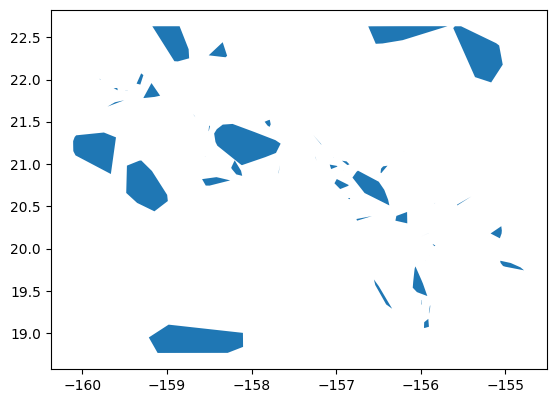

In [ ]:
# plot the extracted polygons to check if everything worked fine
import geopandas
test = geopandas.GeoSeries(waypointsDF['PolygonObj'])
test.plot()

##### Routes identification

In [ ]:
# for each LAT, LON pair, create a shapely.Point
concatDF['PointsObj'] = [shpl.Point(x,y) for (x,y) in concatDF[['LON', 'LAT']].values] #apparently this is faster than usig pandas.Dataframe.apply()

# for each WP, for each row of the entire dataset, check if the point is inside any WP
for name, polygon_obj in  waypointsDF[['Name', 'PolygonObj']].values:
    concatDF[str(name)] = polygon_obj.contains(concatDF['PointsObj']) # create a new column for each wp containing either True or False

# list of column names just created
list_of_columns = [name for name in waypointsDF['Name']]

#idxmax: for each row, return the id (name) of the column containing the first occurrence of the maximum value. There are only bool values so True = 1 > False = 0
# basically returns the name of the WP where the point is contained. If the row has only 'False' values, it returns the first column (this is fixed below)
# this is based on the fact that any given point can belong to either zero or one WP.
concatDF['IsInWP'] = concatDF[list_of_columns].idxmax(axis=1)

# find all rows that have only 'False' values. The '~' negates the values (its like applying the binary NOT)
all_false_rows = concatDF[(~concatDF[list_of_columns]).all(axis=1)].index
# Replace the value in the 'IsInWP' column as 'None'
concatDF.loc[all_false_rows, 'IsInWP'] = None
# drop unnecessary columns
concatDF.drop(list_of_columns, axis=1, inplace=True)

print(concatDF)

              MMSI        BaseDateTime      LAT       LON  SOG         COG  \
0        338199855 2019-01-01 00:00:00  21.3131 -157.8671  0.0  360.000000   
1        338199855 2019-01-01 00:01:09  21.3131 -157.8671  0.0  360.000000   
2        338199855 2019-01-01 00:02:20  21.3131 -157.8671  0.0  360.000000   
3        338199855 2019-01-01 00:03:31  21.3131 -157.8671  0.0  360.000000   
4        338199855 2019-01-01 00:04:39  21.3131 -157.8671  0.0  360.000000   
...            ...                 ...      ...       ...  ...         ...   
5415158  248531000 2019-03-31 23:43:55  21.2779 -158.0725  0.2    3.500000   
5415159  248531000 2019-03-31 23:46:55  21.2779 -158.0725  0.2  174.600006   
5415160  248531000 2019-03-31 23:52:55  21.2779 -158.0725  0.2  198.000000   
5415161  248531000 2019-03-31 23:55:55  21.2779 -158.0725  0.1  182.100006   
5415162  248531000 2019-03-31 23:58:55  21.2779 -158.0725  0.1  181.100006   

         Heading  VesselName  VesselType  Status  Length  Width

IsInWP
WP_45    4036464
None      914311
WP_36     146732
WP_34      83851
WP_11      62089
WP_26      44433
WP_20      31864
WP_37      19647
WP_35      16834
WP_12       6265
WP_46       5910
WP_31       5418
WP_43       4627
WP_16       3796
WP_24       3264
WP_3        3236
WP_5        2671
WP_33       2328
WP_39       2190
WP_17       2102
WP_1        1585
WP_7        1522
WP_23       1491
WP_29       1468
WP_30       1314
WP_4        1302
WP_38       1271
WP_10       1038
WP_9         936
WP_15        896
WP_21        742
WP_32        588
WP_42        563
WP_0         341
WP_14        282
WP_2         281
WP_18        275
WP_19        255
WP_13        199
WP_40        168
WP_44        143
WP_22        140
WP_27         81
WP_8          78
WP_25         59
WP_6          54
WP_28         39
WP_41         20
Name: count, dtype: int64
(5415163, 18)


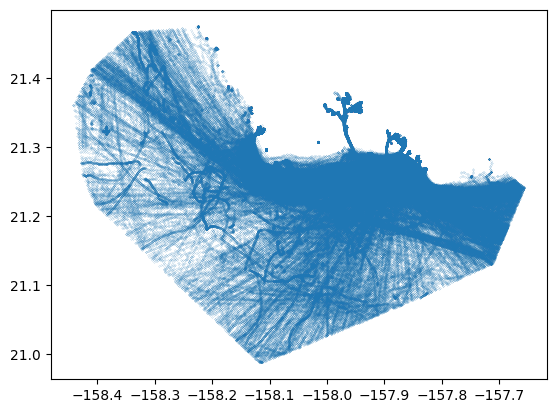

In [ ]:
# count the number of points contained in each WP. None -> the ship is at open sea
value_counts = concatDF['IsInWP'].value_counts(dropna=False)
print(value_counts)
print(concatDF.shape)
# quick plot of the WP with the highest amount of points
testDF = concatDF[concatDF['IsInWP'] == value_counts.index[0]]
plt.scatter(testDF['LON'], testDF['LAT'], s=0.01)

#### Routes extraction
For each vessel contained in V_s (used at the beginning of this notebook), create a new column (called 'Route') specifying the current route.</br>If the ship is inside a WP, than the WP name is used in the new column.</br>If the ship is at open sea ('IsInWP' == None) then the Route column is filled in the following way:
* Let A and B be the names of the start and end WPs, respectively
* If both A and B are known, the route name is built as A - B
* If either one is missing (pd.NA), the route name is built as "\<NA> - B" or "A - \<NA>"

In [ ]:
concatDF['Route'] = p.Series(dtype=p.StringDtype())

for index, unique_mmsi in enumerate(reference_list_of_mmsi):
    vesselDF = concatDF[concatDF['MMSI'] == unique_mmsi].copy()
    
    vesselDF['PreviousWP'] = vesselDF['IsInWP'].ffill()
    '''
    vesselDF['PreviousWP'] = np.where((vesselDF['EstimatedStatus'] == 'lost') |
                                      (vesselDF['EstimatedStatus'] == 'return'),
                                      p.NA,
                                      vesselDF['PreviousWP']
                                      )
    '''

    vesselDF['NextWP'] = vesselDF['IsInWP'].bfill()
    '''
    vesselDF['NextWP'] = np.where((vesselDF['EstimatedStatus'] == 'lost') |
                                      (vesselDF['EstimatedStatus'] == 'return'),
                                      p.NA,
                                      vesselDF['NextWP']
                                      )
    '''
    
    #replace None values with pd.NA, which is like np.NaN but for non-numeric values
    vesselDF['PreviousWP'] = vesselDF['PreviousWP'].fillna(p.NA)
    vesselDF['NextWP'] = vesselDF['NextWP'].fillna(p.NA)

    vesselDF['Route'] = vesselDF['IsInWP'].combine_first(vesselDF['PreviousWP'].astype(str) + ' - ' + vesselDF['NextWP'].astype(str))

    # remove auxiliary columns that aren't necessary anymore
    vesselDF.drop(['PreviousWP', 'NextWP'], axis=1, inplace=True)
    #save df to the list of vessels (V_s)
    V_s[index] = vesselDF.copy()

# save ecerything in the main dataframe (it's not sorted by 'BaseDateTime' anymore)
concatDF = p.concat(V_s).copy()

print(V_s[200][['BaseDateTime', 'MMSI', 'LAT', 'LON', 'EstimatedStatus', 'Avg_Speed', 'IsInWP', 'Route']].to_string())


               BaseDateTime       MMSI      LAT       LON EstimatedStatus  Avg_Speed IsInWP          Route
4133359 2019-01-07 13:29:43  367776630  22.3462 -158.6471           entry       7.90   None   <NA> - WP_45
4133360 2019-01-07 14:29:31  367776630  22.2230 -158.6005          return       7.60   None   <NA> - WP_45
4133361 2019-01-07 14:31:33  367776630  22.2189 -158.5991         sailing       7.63   None   <NA> - WP_45
4133362 2019-01-07 14:34:05  367776630  22.2138 -158.5975         sailing       7.56   None   <NA> - WP_45
4133363 2019-01-07 14:39:08  367776630  22.2035 -158.5946         sailing       7.60   None   <NA> - WP_45
4133364 2019-01-07 14:41:41  367776630  22.1983 -158.5930         sailing       7.65   None   <NA> - WP_45
4133365 2019-01-07 14:42:42  367776630  22.1962 -158.5922         sailing       7.90   None   <NA> - WP_45
4133366 2019-01-07 14:43:43  367776630  22.1940 -158.5916         sailing       8.05   None   <NA> - WP_45
4133367 2019-01-07 14:46:45  36777663

##### Plot ship path on a map

In [ ]:
# -1, -2, 4, 5, 200

to_be_plotted = V_s[200]

# plot route points
fig = px.scatter_mapbox(data_frame = to_be_plotted,
                            lon = to_be_plotted['LON'],
                            lat= to_be_plotted['LAT'],
                            zoom = 7,
                            color = to_be_plotted['Avg_Speed'],
                            title = to_be_plotted.at[to_be_plotted.index[0], 'MMSI'].astype(str),
                            color_continuous_scale='portland',  #portland
                            hover_data=to_be_plotted[['BaseDateTime', 'Avg_Speed', 'Route', 'EstimatedStatus']]
                            )

# add domain border
fig.add_trace(go.Scattermapbox(
                                mode = 'lines',
                                lon = [LON_MIN, LON_MIN, LON_MAX, LON_MAX, LON_MIN],
                                lat = [LAT_MIN, LAT_MAX, LAT_MAX, LAT_MIN, LAT_MIN],
                                marker = {'size':10,
                                          'color': 'red'},
                                uid=2,
                                below=0
                                ))
    
# Add polygons on map
for label in clusteredPointsDF['Label'].unique():
    groupLATLONDF = clusteredPointsDF[clusteredPointsDF['Label']==label][['LAT', 'LON']]
    hull = ConvexHull(groupLATLONDF)
    hull_lon = [groupLATLONDF['LON'].reset_index().iloc[vertex] for vertex in hull.vertices]
    hull_lat = [groupLATLONDF['LAT'].reset_index().iloc[vertex] for vertex in hull.vertices]

    hull_lon = [serie.tolist()[1] for serie in hull_lon]
    hull_lat = [serie.tolist()[1] for serie in hull_lat]

    fig.add_trace(go.Scattermapbox(
        lat=hull_lat + [hull_lat[0]],
        lon=hull_lon + [hull_lon[0]],
        mode='lines',
        line=dict(color='black', width=2),
        below=0,
        showlegend=False,
        name='WP_' + str(label)
        #fill='toself',
        #fillcolor='rgba(255,0,0,0.2)'
    ))

fig.update_layout(mapbox_style = 'open-street-map',
                  margin={'r':0, 't':40, 'l':0, 'b':0},
                  )
po.plot(fig)

'temp-plot.html'

#### Search for the most popular routes

In [ ]:
def count_groups(df, col_name):
    df['shifted'] = df[col_name].shift(1)
    df['change'] = df[col_name] != df['shifted']
    df['group'] = df['change'].cumsum()
    group_counts = df.groupby('group')[col_name].first().value_counts()
    return group_counts

result = {}

for temp_vessel in V_s:
    group_counts = count_groups(temp_vessel, 'Route')
    for key, count in group_counts.items():
        if key not in result.keys():
            result[key] = count
        else:
            result[key] += count

print(p.DataFrame(data={'Name': result.keys(), 'Count': result.values()}).sort_values(by='Count', ascending=False).to_string())

              Name  Count
0            WP_45   1492
10           WP_11   1094
58   WP_11 - WP_11    971
32           WP_36    734
9            WP_37    393
21   WP_45 - WP_45    361
54           WP_20    326
1            WP_34    316
40   WP_36 - WP_37    306
50   WP_37 - WP_36    304
2            WP_39    253
106          WP_46    245
90   WP_20 - WP_20    229
36            WP_3    223
6            WP_12    207
53           WP_31    173
165          WP_26    162
39   WP_36 - WP_36    146
57   WP_34 - WP_34    142
109          WP_43    134
112  WP_46 - WP_45    127
37   WP_45 - WP_36    124
107  WP_45 - WP_46    118
126           WP_5    109
42     WP_3 - WP_3    108
4    WP_39 - WP_45    108
5    WP_34 - WP_39    107
44   WP_36 - WP_45    106
15   WP_12 - WP_11    105
166  WP_26 - WP_26     98
77    WP_45 - <NA>     95
11   WP_11 - WP_12     95
204          WP_24     92
18   WP_39 - WP_34     92
19   WP_45 - WP_39     89
7            WP_38     86
31           WP_35     80
101         